In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torch.distributions as dist
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from GANmodel import *
%load_ext autoreload
%autoreload 2

In [2]:
netG = Generator(3)
netD = Discriminator()
netG.load_state_dict(torch.load("./GANmodels/3dGenerator"))
netD.load_state_dict(torch.load("./GANmodels/3dDiscriminator"))

<All keys matched successfully>

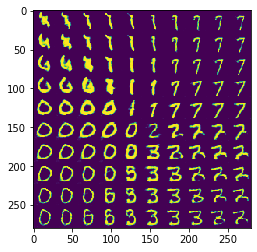

In [3]:
"""Visualize the latent space"""
with torch.no_grad():
    n = 10
    z = torch.cat([torch.linspace(-2.5,2.5,n)[:,None].repeat(n,1), 
                   torch.linspace(2.5,-2.5,n)[:,None].repeat_interleave(n,0),torch.zeros(n**2,1)],1)[:,:,None,None]
    out = netG(z).squeeze().cpu().detach().numpy()
out_grid = np.zeros((28*n,28*n))
grid_vals = np.linspace(-1,1,n)
for i in range(n**2):
    x = (i % n)
    y = (i // n)
    out_grid[x*28:(x+1)*28,y*28:(y+1)*28] = out[i]
plt.imshow(out_grid)

In [4]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
class ImageDataset(Dataset):
    def __init__(self, images, x, t, y, z_dim=1):
        self.length = x.shape[0]
        x_dim = x.shape[1]
        self.images = images
        self.t = t
        self.X = x
        self.y = y

    def __getitem__(self, idx):
        return {
            'image': self.images[idx],
            'X': self.X[idx],
            't': self.t[idx],
            'y': self.y[idx]
        }
    def __len__(self):
        return self.length

In [5]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def generate_image_data(zdim, generator, num_samples, t_a, t_b, y_a0, y_b0, y_a1, y_b1, c_x, s_x):
    z = torch.randn(num_samples, zdim)
    with torch.no_grad():
        #image_expectations = (1+generator(z[:,:,None,None]))/2
        #images = dist.Bernoulli(image_expectations).sample()#This way binary data
        image_means = generator(z[:,:,None,None])
        images = image_means + torch.randn_like(image_means)*0.05 # <- this way continuous data
    z_temp = z[:,0][:,None].detach().numpy()#Use the first dimension for prediction of ordinary variables
    x = torch.Tensor(np.random.normal(np.tile(c_x, (num_samples,1))*z_temp,
                         np.tile(s_x, (num_samples,1)),(num_samples, 1)))
    t = (np.random.random((num_samples, 1)) < sigmoid(t_a*z_temp + t_b)).astype(int)
    y = torch.Tensor((np.random.random((num_samples, 1)) < sigmoid(y_a1*z_temp + y_b1)).astype(int)*t \
        + (np.random.random((num_samples, 1)) < sigmoid(y_a0*z_temp + y_b0)).astype(int)*(1-t))
    t = torch.Tensor(t)
    dataset = ImageDataset(images, x, t, y, zdim)
    return z, images, x, t, y, dataset

In [259]:
class Decoder(nn.Module):
    def __init__(
        self,
        x_dim,
        z_dim,
        device,
        ngf=64,
        nc=1
    ):
        super().__init__()
        self.ct1 = nn.Sequential(nn.ConvTranspose2d(z_dim,4*ngf,kernel_size=4,stride=2,bias=False),nn.ReLU())
        self.ct2 = nn.Sequential(nn.ConvTranspose2d(4*ngf,2*ngf,kernel_size=4,stride=2,padding=1,bias=False), nn.ReLU())
        self.ct3 = nn.Sequential(nn.ConvTranspose2d(2*ngf,ngf,kernel_size=4,stride=2,padding=2,bias=False), nn.ReLU())
        self.ct4 = nn.Sequential(nn.ConvTranspose2d(ngf,nc,kernel_size=4,stride=2,padding=1,bias=False), nn.Tanh())
        self.logstd = nn.Parameter(torch.Tensor([1]))

    def forward(self,z):
        image = self.ct1(z)
        image = self.ct2(image)
        image = self.ct3(image)
        image = self.ct4(image)
        return image, torch.exp(self.logstd)
    
class Encoder(nn.Module):
    def __init__(
        self,
        x_dim,
        z_dim,
        device,
        ngf=64,
        nc=1
    ):
        super().__init__()
        self.c1 = nn.Sequential(nn.Conv2d(nc,ngf,kernel_size=4,stride=2,padding=1,bias=False), nn.ReLU())
        self.c2 = nn.Sequential(nn.Conv2d(ngf,2*ngf,kernel_size=4,stride=2,padding=2,bias=False), nn.ReLU())
        self.c3 = nn.Sequential(nn.Conv2d(2*ngf,4*ngf,kernel_size=4,stride=2,padding=1,bias=False), nn.ReLU())
        self.c4 = nn.Sequential(nn.Conv2d(4*ngf,100,kernel_size=4,stride=2,bias=False))
        self.mean = nn.Linear(100,z_dim)
        self.logstd = nn.Linear(100,z_dim)
    
    def forward(self,image):
        z = self.c1(image)
        z = self.c2(z)
        z = self.c3(z)
        z = self.c4(z)
        z_mean = self.mean(z[:,:,0,0])[:,:,None,None]
        z_std = torch.exp(self.logstd(z[:,:,0,0]))[:,:,None,None]
        return z_mean,z_std

class ImageVAE(nn.Module):
    def __init__(
        self, 
        x_dim,
        z_dim=1,
        device='cpu'
    ):
        super().__init__()
        
        self.x_dim = x_dim
        self.z_dim = z_dim
        self.device = device
        
        self.encoder = Encoder(
            x_dim,
            z_dim,
            device=device
        )
        self.decoder = Decoder(
            x_dim,
            z_dim,
            device=device
        )
        self.to(device)
        self.float()

    def reparameterize(self, mean, std):
        # samples from unit norm and does reparam trick
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)

    def forward(self, image):#Should have t, y
        z_mean, z_std = self.encoder(image)
        #TODO: works at least for z_dim=1, maybe errors if z_dim>1
        z = self.reparameterize(z_mean, z_std)
        
        image, image_std = self.decoder(z)
        
        return image, image_std, z_mean, z_std

In [6]:
def kld_loss(mu, std):
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    #Note that the sum is over the dimensions of z as well as over the units in the batch here
    var = std.pow(2)
    kld = -0.5 * torch.sum(1 + torch.log(var) - mu.pow(2) - var)
    return kld

In [7]:
c_x = np.array([1])
s_x = np.array([0.5])
t_a = np.array([1])
t_b = np.array([0.5])
y_a0 = np.array([2])
y_b0 = np.array([-0.5])
y_a1 = np.array([2])
y_b1 = np.array([0.5])
num_samples = 5000
images, x, t, y, dataset = generate_image_data(3,netG, num_samples, t_a, t_b, y_a0, y_b0, y_a1, y_b1, c_x, s_x)

In [8]:
dataloader = DataLoader(dataset, batch_size=10)#ImageDataLoader(dataset)

In [267]:
device = 'cuda'
z_dim = 3
model = ImageVAE(1,z_dim,device=device)
optimizer = Adam(model.parameters(), lr=0.001)

Epoch 0:
tensor(7238.9121, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6560.4795, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5949.7280, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5485.3267, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4696.5010, device='cuda:0', grad_fn=<AddBackward0>)


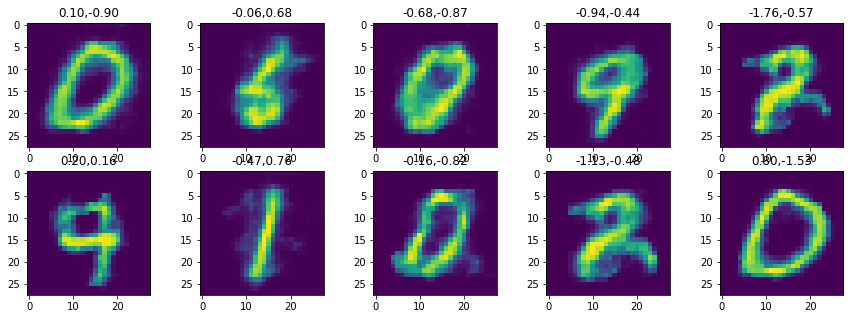

Epoch 1:
tensor(4421.0942, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3751.7878, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3439.8274, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3205.4165, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2356.3982, device='cuda:0', grad_fn=<AddBackward0>)


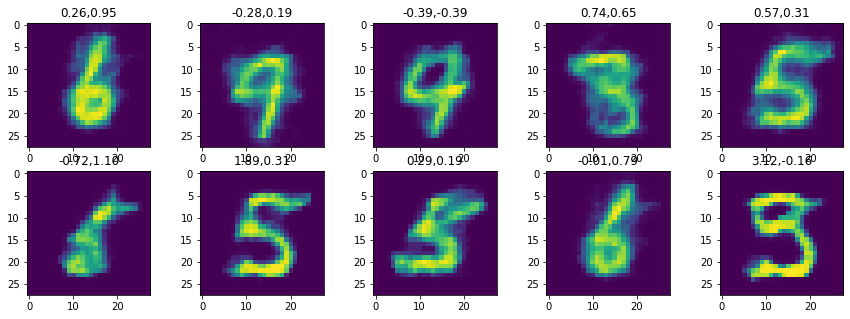

Epoch 2:
tensor(3050.6392, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1701.2783, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2130.5386, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2092.9084, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1143.7883, device='cuda:0', grad_fn=<AddBackward0>)


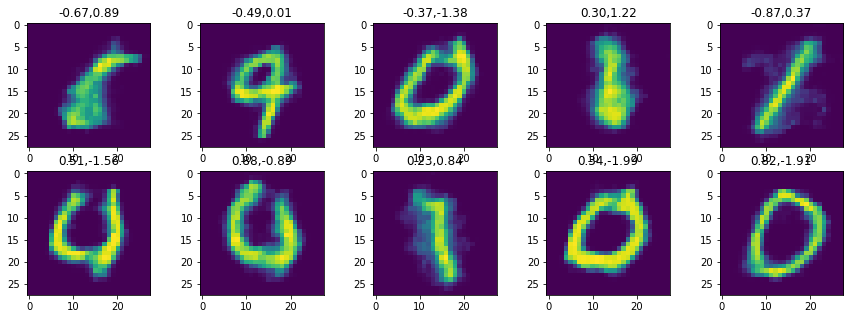

Epoch 3:
tensor(2194.7446, device='cuda:0', grad_fn=<AddBackward0>)
tensor(753.4551, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1288.5232, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1616.1382, device='cuda:0', grad_fn=<AddBackward0>)
tensor(492.3260, device='cuda:0', grad_fn=<AddBackward0>)


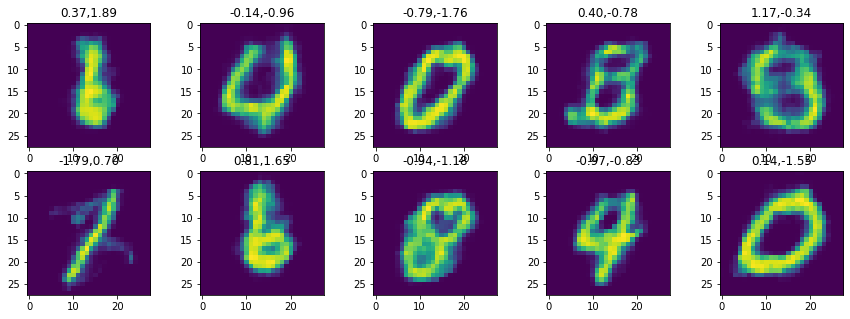

Epoch 4:
tensor(1796.0028, device='cuda:0', grad_fn=<AddBackward0>)
tensor(775.4876, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1153.4153, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1467.6454, device='cuda:0', grad_fn=<AddBackward0>)
tensor(404.9297, device='cuda:0', grad_fn=<AddBackward0>)


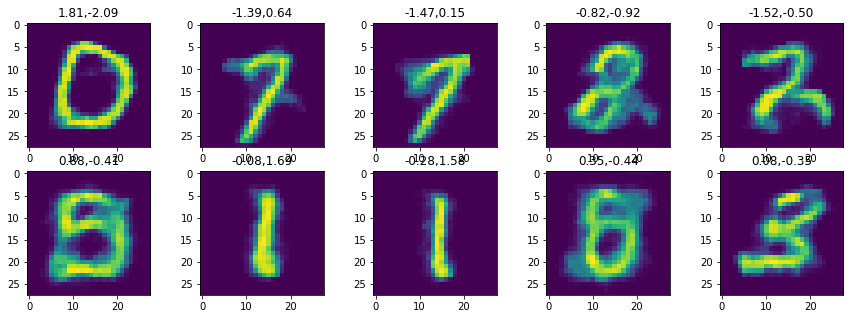

Epoch 5:
tensor(1338.8503, device='cuda:0', grad_fn=<AddBackward0>)
tensor(69.9369, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1060.6499, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1175.7113, device='cuda:0', grad_fn=<AddBackward0>)
tensor(51.7194, device='cuda:0', grad_fn=<AddBackward0>)


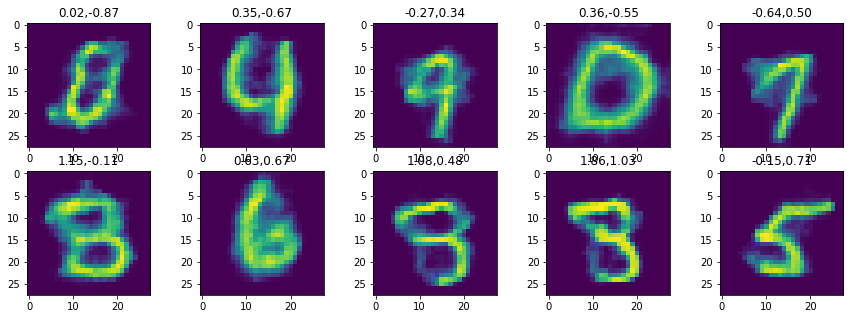

Epoch 6:
tensor(706.7430, device='cuda:0', grad_fn=<AddBackward0>)
tensor(132.0086, device='cuda:0', grad_fn=<AddBackward0>)
tensor(815.2073, device='cuda:0', grad_fn=<AddBackward0>)
tensor(799.9427, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-45.6668, device='cuda:0', grad_fn=<AddBackward0>)


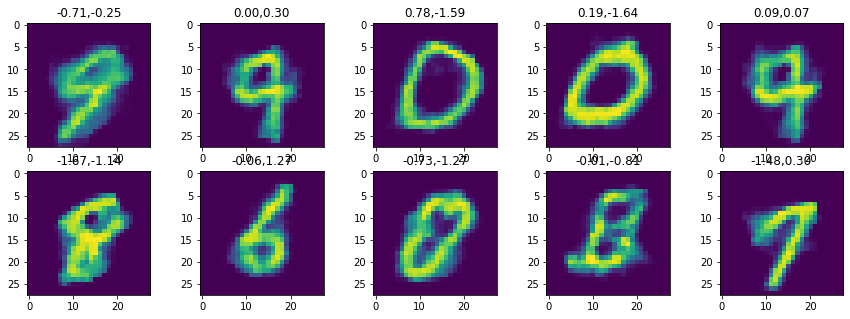

Epoch 7:
tensor(789.0671, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-130.5297, device='cuda:0', grad_fn=<AddBackward0>)
tensor(788.4930, device='cuda:0', grad_fn=<AddBackward0>)
tensor(570.7903, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-178.9433, device='cuda:0', grad_fn=<AddBackward0>)


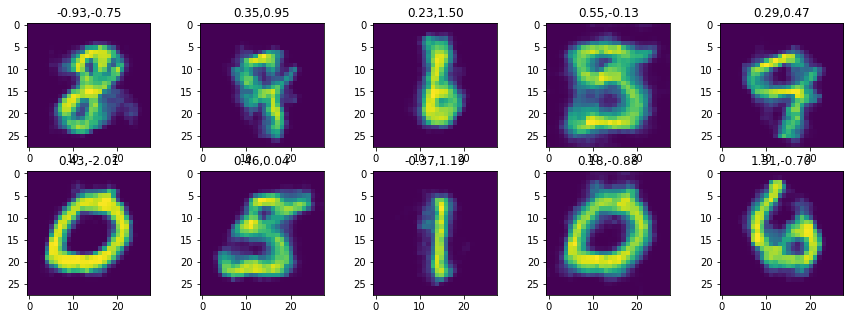

Epoch 8:
tensor(777.6332, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-537.4037, device='cuda:0', grad_fn=<AddBackward0>)
tensor(402.8792, device='cuda:0', grad_fn=<AddBackward0>)
tensor(632.0457, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-593.7252, device='cuda:0', grad_fn=<AddBackward0>)


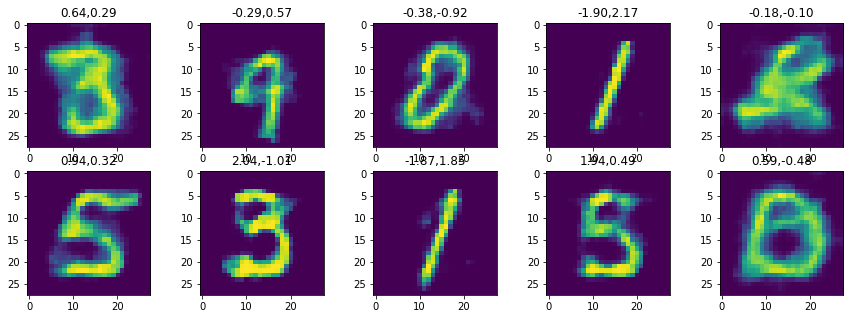

Epoch 9:
tensor(412.7295, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-709.5024, device='cuda:0', grad_fn=<AddBackward0>)
tensor(443.8551, device='cuda:0', grad_fn=<AddBackward0>)
tensor(918.2609, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-637.1345, device='cuda:0', grad_fn=<AddBackward0>)


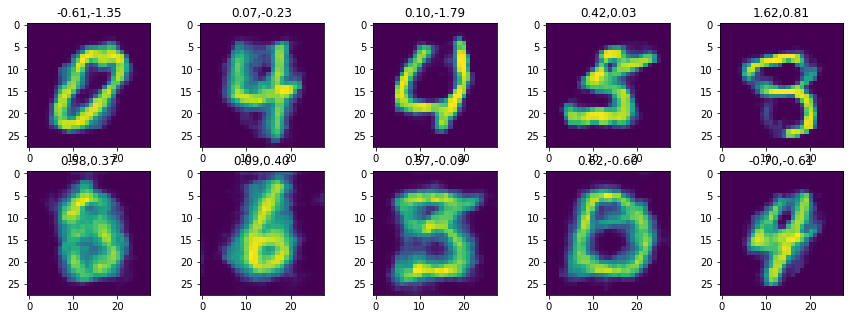

Epoch 10:
tensor(618.2598, device='cuda:0', grad_fn=<AddBackward0>)
tensor(219.0585, device='cuda:0', grad_fn=<AddBackward0>)
tensor(514.7936, device='cuda:0', grad_fn=<AddBackward0>)
tensor(744.2684, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-577.5517, device='cuda:0', grad_fn=<AddBackward0>)


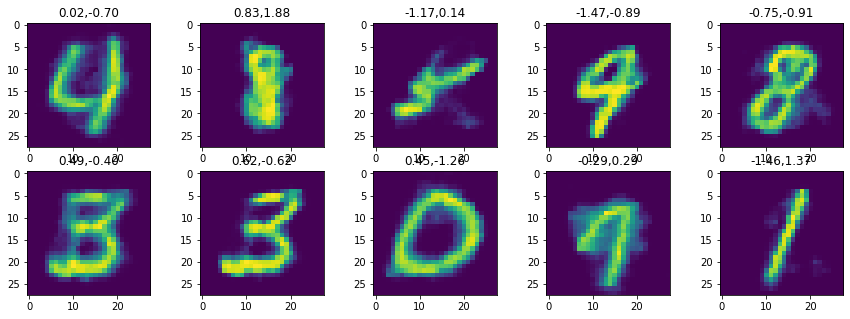

Epoch 11:
tensor(87.4566, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-472.4096, device='cuda:0', grad_fn=<AddBackward0>)
tensor(488.0343, device='cuda:0', grad_fn=<AddBackward0>)
tensor(647.4285, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-708.8936, device='cuda:0', grad_fn=<AddBackward0>)


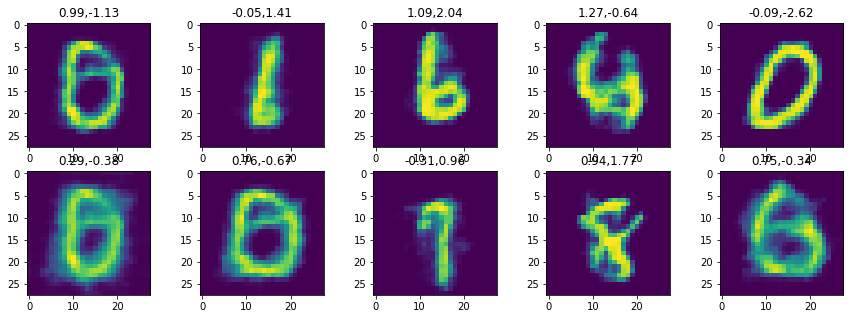

Epoch 12:
tensor(217.1398, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-597.4012, device='cuda:0', grad_fn=<AddBackward0>)
tensor(356.6049, device='cuda:0', grad_fn=<AddBackward0>)
tensor(692.2218, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-807.7627, device='cuda:0', grad_fn=<AddBackward0>)


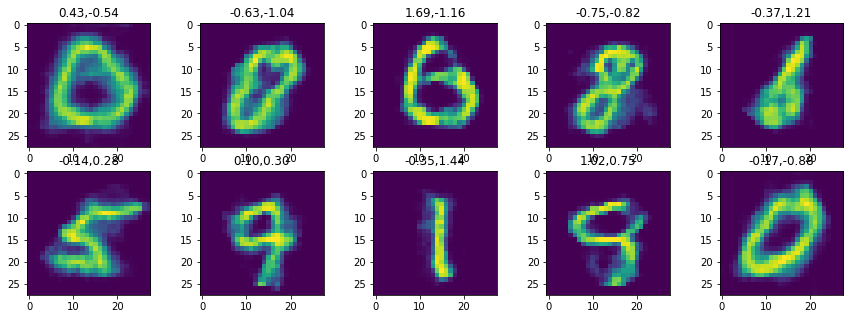

Epoch 13:
tensor(849.7025, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-586.8412, device='cuda:0', grad_fn=<AddBackward0>)
tensor(209.8920, device='cuda:0', grad_fn=<AddBackward0>)
tensor(479.6869, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-852.9377, device='cuda:0', grad_fn=<AddBackward0>)


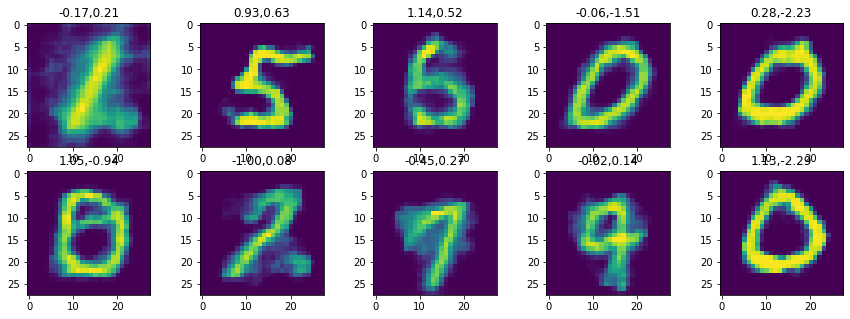

Epoch 14:
tensor(-2.6052, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-906.0853, device='cuda:0', grad_fn=<AddBackward0>)
tensor(252.9474, device='cuda:0', grad_fn=<AddBackward0>)
tensor(531.5339, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-816.5167, device='cuda:0', grad_fn=<AddBackward0>)


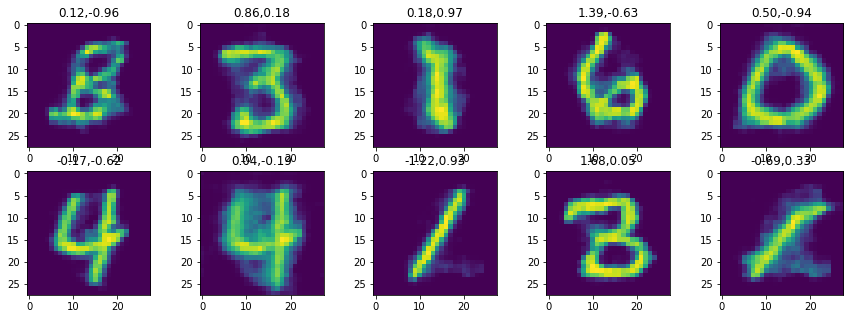

Epoch 15:
tensor(-129.4299, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-568.3610, device='cuda:0', grad_fn=<AddBackward0>)
tensor(534.1591, device='cuda:0', grad_fn=<AddBackward0>)
tensor(242.9566, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1056.9973, device='cuda:0', grad_fn=<AddBackward0>)


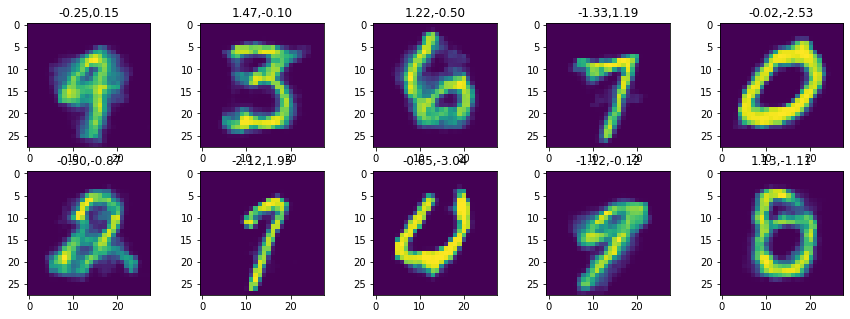

Epoch 16:
tensor(93.8303, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-918.8891, device='cuda:0', grad_fn=<AddBackward0>)
tensor(55.7438, device='cuda:0', grad_fn=<AddBackward0>)
tensor(389.5274, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1207.6646, device='cuda:0', grad_fn=<AddBackward0>)


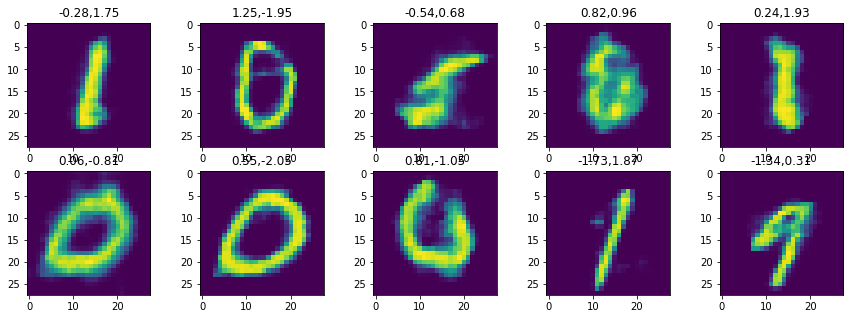

Epoch 17:
tensor(-248.8933, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-385.2802, device='cuda:0', grad_fn=<AddBackward0>)
tensor(387.9512, device='cuda:0', grad_fn=<AddBackward0>)
tensor(368.8384, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-686.1557, device='cuda:0', grad_fn=<AddBackward0>)


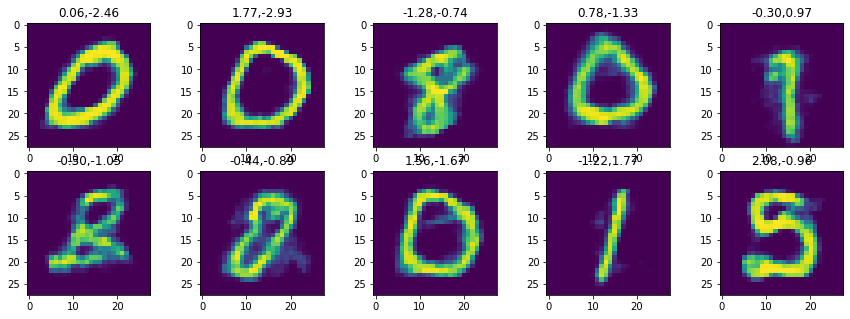

Epoch 18:
tensor(20.7339, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1229.6318, device='cuda:0', grad_fn=<AddBackward0>)
tensor(754.1762, device='cuda:0', grad_fn=<AddBackward0>)
tensor(237.6216, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-997.6636, device='cuda:0', grad_fn=<AddBackward0>)


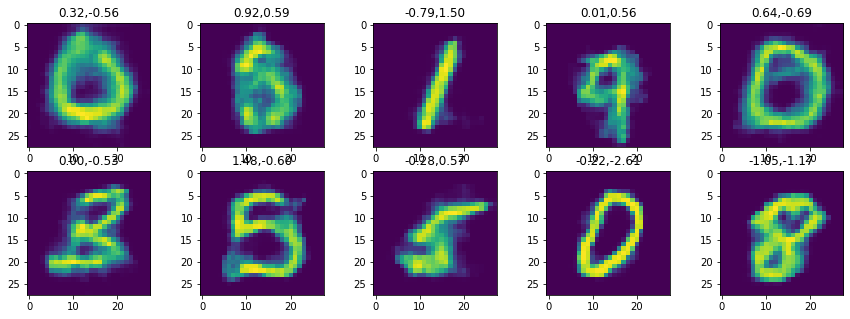

Epoch 19:
tensor(-82.0226, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1067.0094, device='cuda:0', grad_fn=<AddBackward0>)
tensor(125.5877, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-341.5836, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1229.3401, device='cuda:0', grad_fn=<AddBackward0>)


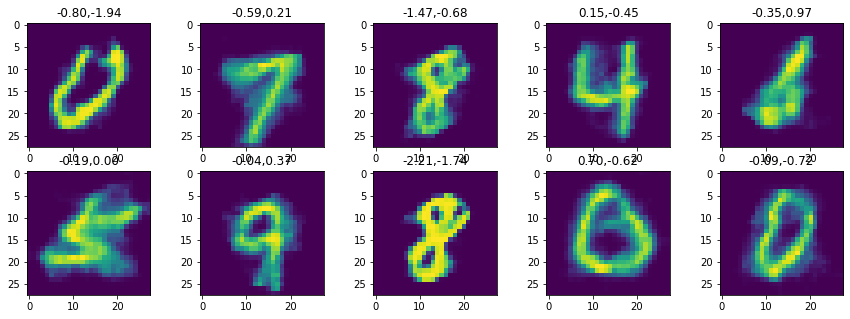

In [271]:
for epoch in range(20):
    i = 0
    print("Epoch {}:".format(epoch))
    for data in dataloader:
        image = data['image'].to(device)
        image_mean, image_std, z_mean, z_std = model(image)
        kld = kld_loss(z_mean, z_std)
        image_loss = -dist.Normal(loc=image_mean, scale = image_std).log_prob(image).sum()
        loss = kld + image_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        i += 1
        if i%100 == 0:
            print(loss)
    
    fig,ax = plt.subplots(2,5, figsize=(15,5))
    with torch.no_grad():
        z = torch.randn(10,z_dim,1,1).to(device)
        out, _ = model.decoder(z)
        out = out.squeeze().cpu().detach().numpy()
        for i in range(10):
            x = i % 5
            y = i // 5
            ax[y][x].imshow(out[i])
            ax[y][x].set_title("{:.2f},{:.2f}".format(z[i,0,0,0],z[i,1,0,0]))
    plt.show()

In [205]:
model = imageVAE(1,3)
image = model(dataset[0]['image'][None,:,:,:])

torch.Size([1, 100, 1, 1])


In [209]:
image[0].shape

torch.Size([1, 1, 28, 28])

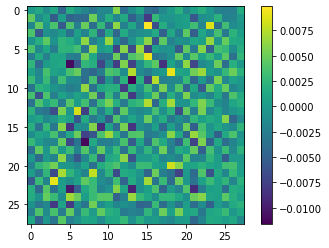

In [211]:
plt.imshow(image[0].squeeze().detach().numpy())
plt.colorbar()

In [152]:
import pandas as pd
c_x = np.array([1])
s_x = np.array([0.5])
t_a = np.array([1])
t_b = np.array([0.5])
y_a0 = np.array([2])
y_b0 = np.array([-0.5])
y_a1 = np.array([2])
y_b1 = np.array([0.5])
num_samples = 5000
z, images, x, t, y, dataset = generate_image_data(3,netG, num_samples, t_a, t_b, y_a0, y_b0, y_a1, y_b1, c_x, s_x)
#TODO: run logistic regression models on y|z,t to get the ATE:s that can be gotten with the data

In [153]:
df = pd.DataFrame(torch.cat([z,x,t,y],1).detach().numpy(), columns=['z{}'.format(i) for i in range(3)] + ['x', 't', 'y'])
from sklearn.linear_model import LogisticRegression
logreg_t1 = LogisticRegression(penalty='none')
logreg_t0 = LogisticRegression(penalty='none')
logreg_t1.fit(X=df[df.t==1].iloc[:,:1],y=df[df.t==1]['y'])
logreg_t0.fit(X=df[df.t==0].iloc[:,:1],y=df[df.t==0]['y'])
print(logreg_t1.intercept_)
print(logreg_t1.coef_)
print(logreg_t0.intercept_)
print(logreg_t0.coef_)
z_sample = np.random.randn(1000000,1)
p_y_dot1_best = logreg_t1.predict_proba(z_sample)[:,1].mean()
p_y_dot0_best = logreg_t0.predict_proba(z_sample)[:,1].mean()
print("Best Estimated ATE: {}".format(p_y_dot1_best-p_y_dot0_best))
print("p(y=1|do(t=1)): {}".format(p_y_dot1_best))
print("p(y=1|do(t=0)): {}".format(p_y_dot0_best))

[0.47915617]
[[1.98560266]]
[-0.49403414]
[[1.85210498]]
Best Estimated ATE: 0.1501167753001767
p(y=1|do(t=1)): 0.5727481870260686
p(y=1|do(t=0)): 0.42263141172589186


In [154]:
dataloader = DataLoader(dataset, batch_size=10)

In [155]:
from lineardatatools import p_y_zt_from_true_dist, linear_binary_ty_ate

In [156]:
import scipy
def estimate_imageCEVAE_ATE(model):
    """Uses Monte Carlo Integration"""
    z_dim = model.z_dim
    device = model.device
    n = 100000
    z = torch.randn(n,z_dim).to(device)
    py_dot1 = torch.sigmoid(model.decoder.y1_nn(z)).mean()
    py_dot0 = torch.sigmoid(model.decoder.y0_nn(z)).mean()
    ATE = py_dot1 - py_dot0
    return ATE, py_dot1, py_dot0

def linear_binary_ty_ate(p_y_zt1_func, p_y_zt0_func):
    """Calculates the ATE assuming the standard normal p(z) distribution and given P(y|z,t).
    Assumes z_dim==1 for the model."""
    p_y_dot1,_ = scipy.integrate.quad(lambda z: scipy.stats.norm.pdf(z)*p_y_zt1_func(z), -np.inf, np.inf)
    p_y_dot0,_ = scipy.integrate.quad(lambda z: scipy.stats.norm.pdf(z)*p_y_zt0_func(z), -np.inf, np.inf)
    return p_y_dot1, p_y_dot0


In [157]:
"""Get the true ATE"""
p_y_zt1, p_y_zt0 = p_y_zt_from_true_dist(y_a0, y_b0, y_a1, y_b1)
p_y_dot1_true, p_y_dot0_true = linear_binary_ty_ate(p_y_zt1, p_y_zt0)
print(p_y_dot1_true - p_y_dot0_true)
print(p_y_dot1_true)
print(p_y_dot0_true)

0.15048506347526708
0.5752425317376335
0.42475746826236643


In [161]:
from imageCEVAE import ImageCEVAE
device = 'cuda'
z_dim = 5
model = ImageCEVAE(1,z_dim,device=device,p_y_zt_nn=True,p_t_z_nn=True, p_x_z_nn=True)
optimizer = Adam(model.parameters(), lr=0.001)

Epoch 0:
tensor(26.6658, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.3814, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.6500, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.5528, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.9752, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17000609636306763, p(y=1|do(t=1)): 0.5832173824310303, p(y=1|do(t=0)): 0.41321128606796265
Epoch loss: 16003.66796875
Image: 2857.876708984375, x: 2489.587890625, t: 2902.908203125, y: 2243.218994140625



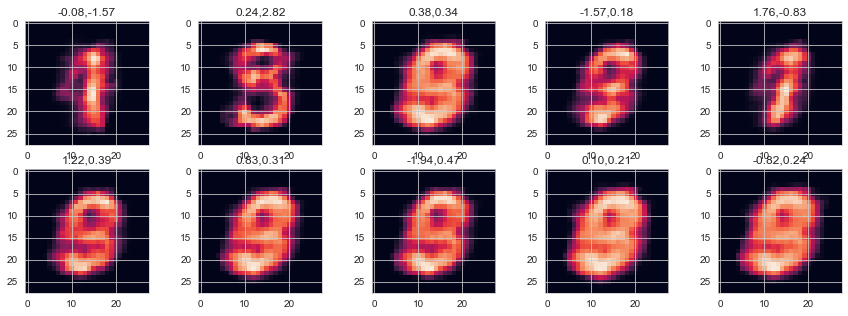

Epoch 1:
tensor(30.8555, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.1621, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.1757, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.1268, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.2212, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17226731777191162, p(y=1|do(t=1)): 0.5839869976043701, p(y=1|do(t=0)): 0.4117196798324585
Epoch loss: 16074.8828125
Image: 2862.2890625, x: 2541.475341796875, t: 2904.505859375, y: 2260.4873046875



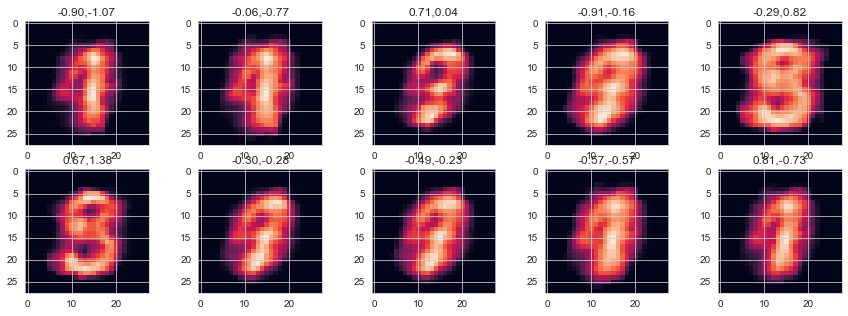

Epoch 2:
tensor(29.7698, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.4783, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.6063, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.3633, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.5339, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17476725578308105, p(y=1|do(t=1)): 0.585085928440094, p(y=1|do(t=0)): 0.41031867265701294
Epoch loss: 16080.193359375
Image: 2859.50439453125, x: 2566.7197265625, t: 2890.060546875, y: 2245.440185546875



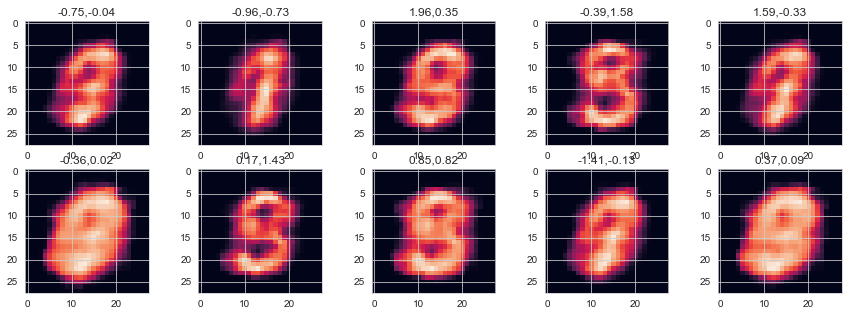

Epoch 3:
tensor(27.7822, device='cuda:0', grad_fn=<AddBackward0>)
tensor(40.3772, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.7696, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.5421, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.1882, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17514878511428833, p(y=1|do(t=1)): 0.5846188068389893, p(y=1|do(t=0)): 0.4094700217247009
Epoch loss: 16025.3564453125
Image: 2860.58935546875, x: 2622.819580078125, t: 2891.70654296875, y: 2241.221923828125



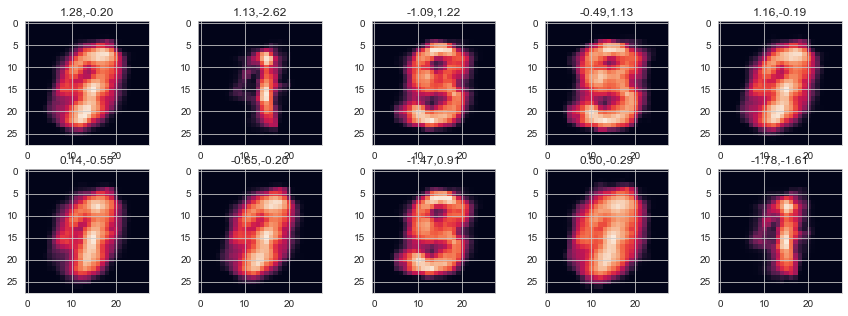

Epoch 4:
tensor(31.2006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.8545, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.0392, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.0062, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.1527, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17539337277412415, p(y=1|do(t=1)): 0.5835451483726501, p(y=1|do(t=0)): 0.408151775598526
Epoch loss: 16144.318359375
Image: 2865.045654296875, x: 2689.054443359375, t: 2888.611328125, y: 2249.684814453125



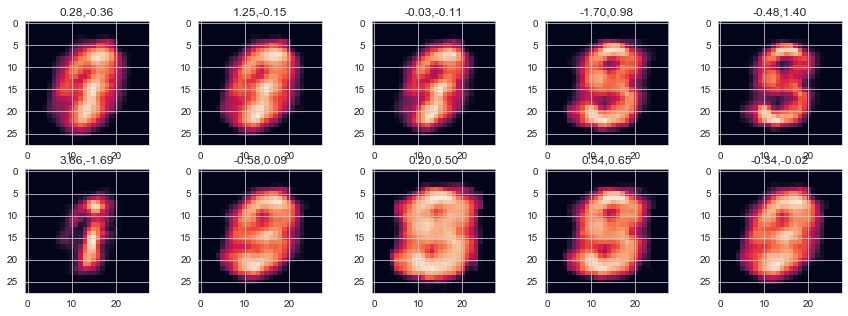

Epoch 5:
tensor(27.3112, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.0376, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.3001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.7871, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.0491, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17517659068107605, p(y=1|do(t=1)): 0.5848990082740784, p(y=1|do(t=0)): 0.4097224175930023
Epoch loss: 16104.4599609375
Image: 2864.39794921875, x: 2692.26171875, t: 2901.084228515625, y: 2247.23486328125



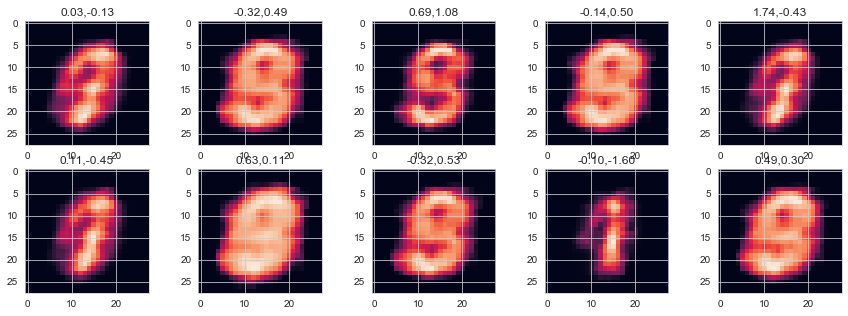

Epoch 6:
tensor(32.4968, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.8884, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.1113, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.9299, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.8179, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17475900053977966, p(y=1|do(t=1)): 0.5838426947593689, p(y=1|do(t=0)): 0.40908369421958923
Epoch loss: 15966.9130859375
Image: 2864.915283203125, x: 2722.86474609375, t: 2920.17333984375, y: 2243.565673828125



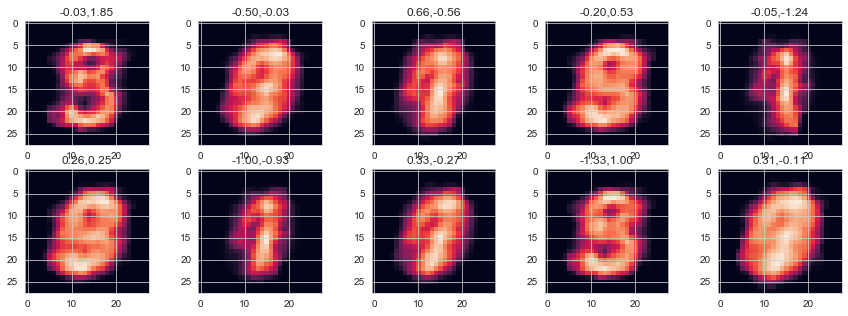

Epoch 7:
tensor(27.9433, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.9222, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.5675, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.8688, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.7489, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17556646466255188, p(y=1|do(t=1)): 0.5862044095993042, p(y=1|do(t=0)): 0.4106379449367523
Epoch loss: 16034.4267578125
Image: 2867.9599609375, x: 2783.025146484375, t: 2899.04296875, y: 2224.21435546875



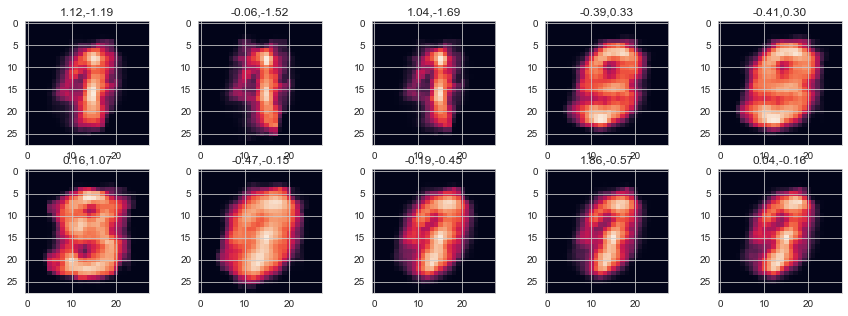

Epoch 8:
tensor(31.5612, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.3327, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.7034, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.9393, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.9244, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17646998167037964, p(y=1|do(t=1)): 0.5841376185417175, p(y=1|do(t=0)): 0.4076676368713379
Epoch loss: 16120.548828125
Image: 2870.859375, x: 2809.381591796875, t: 2908.772705078125, y: 2244.767578125



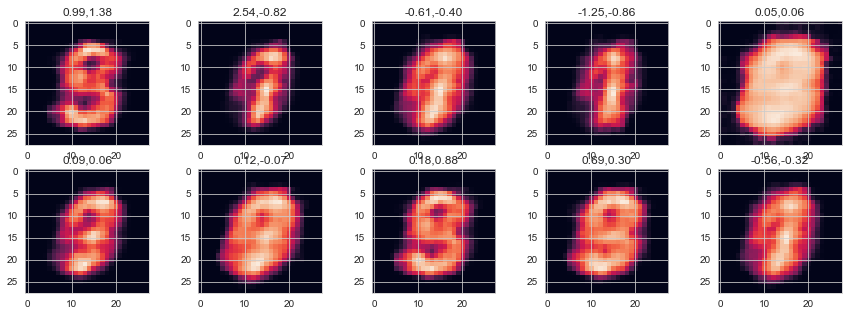

Epoch 9:
tensor(28.1009, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.0333, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.7341, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.7166, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.5550, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17581111192703247, p(y=1|do(t=1)): 0.5850163698196411, p(y=1|do(t=0)): 0.40920525789260864
Epoch loss: 15962.25
Image: 2868.755859375, x: 2812.321044921875, t: 2891.96728515625, y: 2236.128662109375



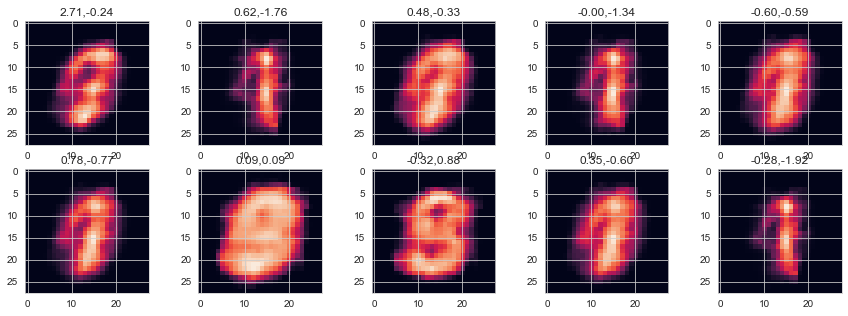

Epoch 10:
tensor(27.9205, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.7392, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.6299, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.1769, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.1382, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17499911785125732, p(y=1|do(t=1)): 0.5832402110099792, p(y=1|do(t=0)): 0.4082410931587219
Epoch loss: 16093.19921875
Image: 2870.565185546875, x: 2874.3974609375, t: 2878.16455078125, y: 2214.836669921875



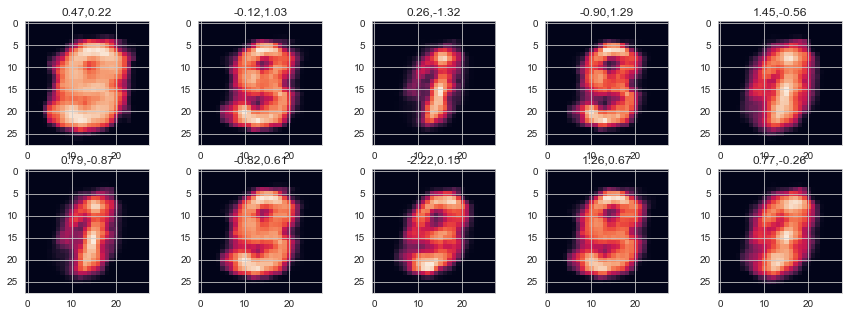

Epoch 11:
tensor(28.1438, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.0053, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.6835, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.2921, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.9157, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17665058374404907, p(y=1|do(t=1)): 0.5851989984512329, p(y=1|do(t=0)): 0.40854841470718384
Epoch loss: 16008.2568359375
Image: 2870.981201171875, x: 2869.507080078125, t: 2890.62060546875, y: 2247.463623046875



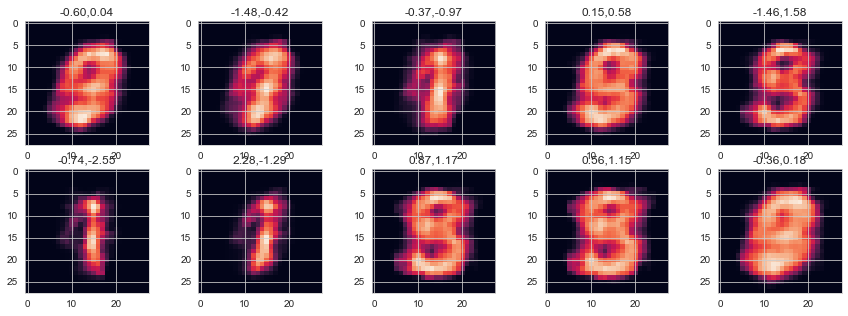

Epoch 12:
tensor(26.5384, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.6790, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.1730, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.9086, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.3507, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17710018157958984, p(y=1|do(t=1)): 0.5860722064971924, p(y=1|do(t=0)): 0.40897202491760254
Epoch loss: 16041.2529296875
Image: 2873.67626953125, x: 2894.3662109375, t: 2891.347412109375, y: 2235.06103515625



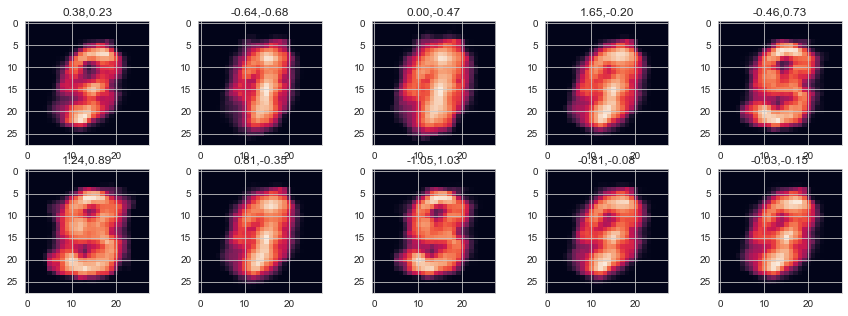

Epoch 13:
tensor(29.3675, device='cuda:0', grad_fn=<AddBackward0>)
tensor(37.3907, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.3151, device='cuda:0', grad_fn=<AddBackward0>)
tensor(37.3439, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.4880, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17737531661987305, p(y=1|do(t=1)): 0.5842124819755554, p(y=1|do(t=0)): 0.4068371653556824
Epoch loss: 16000.93359375
Image: 2866.6640625, x: 2919.878173828125, t: 2884.944091796875, y: 2236.10546875



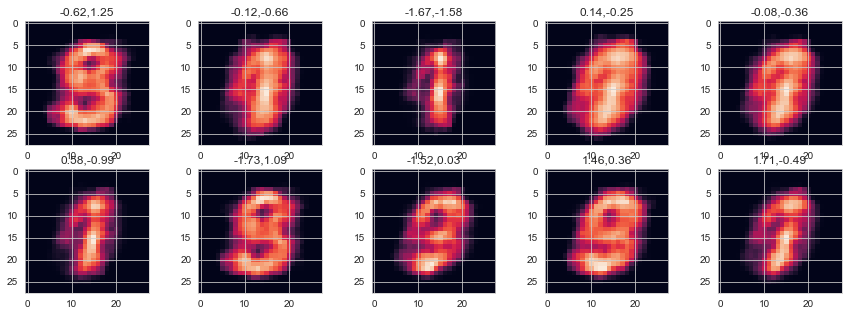

Epoch 14:
tensor(28.7191, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.9427, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.6591, device='cuda:0', grad_fn=<AddBackward0>)
tensor(37.0960, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.6729, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17750048637390137, p(y=1|do(t=1)): 0.5855990052223206, p(y=1|do(t=0)): 0.4080985188484192
Epoch loss: 16060.232421875
Image: 2867.68603515625, x: 2908.44091796875, t: 2888.16162109375, y: 2240.194580078125



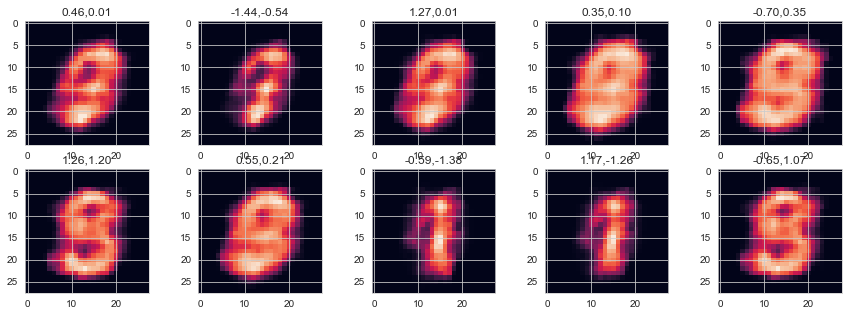

Epoch 15:
tensor(30.4771, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.4581, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.4615, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.3709, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.9062, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.178748220205307, p(y=1|do(t=1)): 0.5861086845397949, p(y=1|do(t=0)): 0.4073604643344879
Epoch loss: 15976.98046875
Image: 2874.106201171875, x: 2999.580078125, t: 2872.363525390625, y: 2221.629638671875



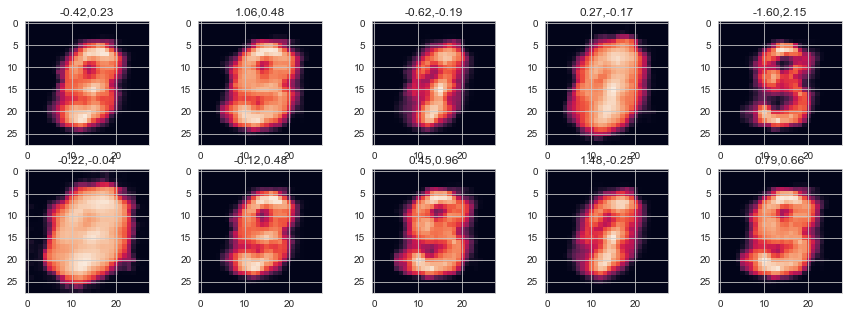

Epoch 16:
tensor(28.1793, device='cuda:0', grad_fn=<AddBackward0>)
tensor(41.1312, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.7498, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.7372, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.1248, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17897966504096985, p(y=1|do(t=1)): 0.5866616368293762, p(y=1|do(t=0)): 0.40768197178840637
Epoch loss: 16090.2880859375
Image: 2864.05322265625, x: 3014.180419921875, t: 2874.68896484375, y: 2240.66015625



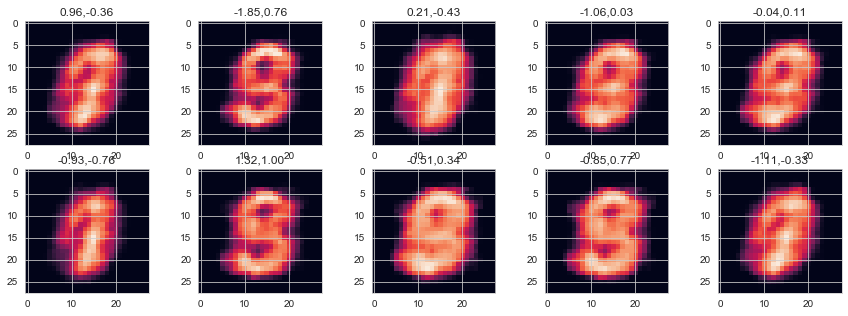

Epoch 17:
tensor(28.4102, device='cuda:0', grad_fn=<AddBackward0>)
tensor(38.2754, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.4895, device='cuda:0', grad_fn=<AddBackward0>)
tensor(33.9642, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.7106, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17739495635032654, p(y=1|do(t=1)): 0.5863609313964844, p(y=1|do(t=0)): 0.40896597504615784
Epoch loss: 16000.0947265625
Image: 2871.634521484375, x: 3071.662841796875, t: 2860.03173828125, y: 2231.740478515625



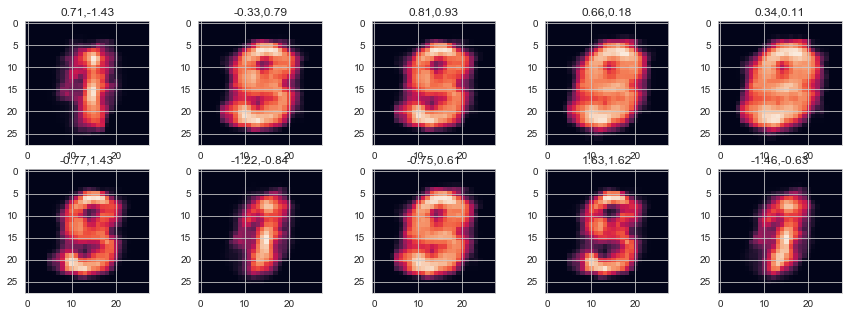

Epoch 18:
tensor(29.9654, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.7863, device='cuda:0', grad_fn=<AddBackward0>)
tensor(30.6744, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.2711, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.4703, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17652153968811035, p(y=1|do(t=1)): 0.5843407511711121, p(y=1|do(t=0)): 0.4078192114830017
Epoch loss: 16056.916015625
Image: 2871.340087890625, x: 3042.289794921875, t: 2902.535400390625, y: 2220.23779296875



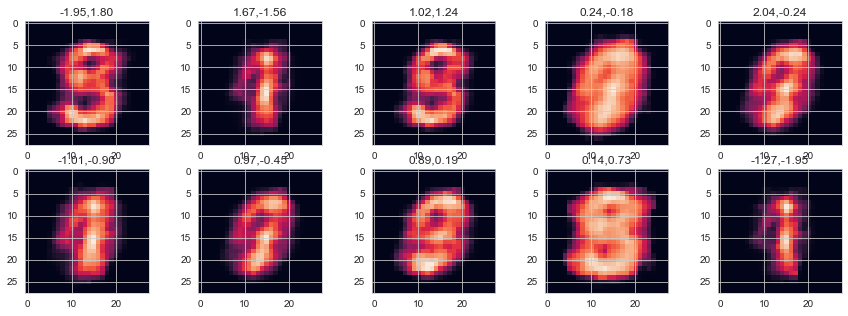

Epoch 19:
tensor(30.4905, device='cuda:0', grad_fn=<AddBackward0>)
tensor(36.5261, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.1287, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.5618, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.5899, device='cuda:0', grad_fn=<AddBackward0>)
Estimated ATE 0.17654818296432495, p(y=1|do(t=1)): 0.5850300192832947, p(y=1|do(t=0)): 0.4084818363189697
Epoch loss: 15997.3818359375
Image: 2874.938232421875, x: 3012.087646484375, t: 2873.15087890625, y: 2230.701171875



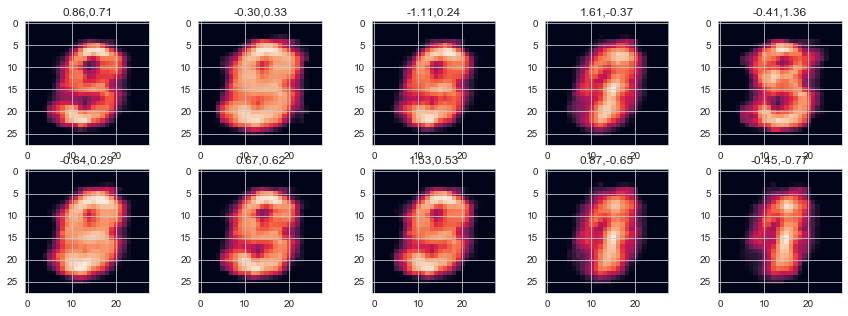

In [163]:
for epoch in range(20):
    i = 0
    print("Epoch {}:".format(epoch))
    epoch_loss = 0
    epoch_image_loss = 0
    epoch_x_loss = 0
    epoch_t_loss = 0
    epoch_y_loss = 0
    for data in dataloader:
        image = data['image'].to(device)
        x = data['X'].to(device)
        t = data['t'].to(device)
        y = data['y'].to(device)
        image_mean, image_std, z_mean, z_std, x_pred, x_std, t_pred, y_pred = model(image,x,t,y)
        kld = kld_loss(z_mean, z_std)
        image_loss = -dist.Normal(loc=image_mean, scale = image_std).log_prob(image).sum()*0.001
        x_loss = -dist.Normal(loc=x_pred, scale = x_std).log_prob(x).sum()
        t_loss = -dist.Bernoulli(logits=t_pred).log_prob(t).sum()
        y_loss = -dist.Bernoulli(logits=y_pred).log_prob(y).sum()
        loss = kld + image_loss + x_loss + t_loss + y_loss
        #loss = kld + x_loss + t_loss + y_loss
        #loss = kld + image_loss + t_loss + y_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss
        epoch_image_loss += image_loss
        epoch_x_loss += x_loss
        epoch_t_loss += t_loss
        epoch_y_loss += y_loss
        
        i += 1
        if i%100 == 0:
            print(loss)
    
    fig,ax = plt.subplots(2,5, figsize=(15,5))
    with torch.no_grad():
        z = torch.randn(10,z_dim).to(device)
        out, _, _, _, _, _ = model.decoder(z,torch.zeros(z.shape[0],1).to(device))
        out = out.squeeze().cpu().detach().numpy()
        for i in range(10):
            x = i % 5
            y = i // 5
            ax[y][x].imshow(out[i])
            ax[y][x].set_title("{:.2f},{:.2f}".format(z[i,0],z[i,1]))
    print("Estimated ATE {}, p(y=1|do(t=1)): {}, p(y=1|do(t=0)): {}".format(*estimate_imageCEVAE_ATE(model)))
    print("Epoch loss: {}".format(epoch_loss))
    print("Image: {}, x: {}, t: {}, y: {}".format(epoch_image_loss, epoch_x_loss,epoch_t_loss,epoch_y_loss))
    print()
    plt.show()

In [149]:
estimate_imageCEVAE_ATE(model)

(tensor(0.1207, device='cuda:0', grad_fn=<SubBackward0>),
 tensor(0.5585, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.4377, device='cuda:0', grad_fn=<MeanBackward0>))

In [87]:
print(model.decoder.y0_nn.bias)
print(torch.sqrt(((model.decoder.x_nns[0].weight)**2).sum()))
print(torch.exp(model.decoder.x_log_std))

Parameter containing:
tensor([-0.4193], device='cuda:0', requires_grad=True)
tensor(0.9975, device='cuda:0', grad_fn=<SqrtBackward>)
tensor([0.5150], device='cuda:0', grad_fn=<ExpBackward>)


In [88]:
print(model.decoder.y0_nn.weight / torch.sqrt(model.decoder.y0_nn.weight**2).sum())
print(model.decoder.y1_nn.weight / torch.sqrt(model.decoder.y1_nn.weight**2).sum())
print(model.decoder.t_nn.weight / torch.sqrt(model.decoder.t_nn.weight**2).sum())
print(model.decoder.x_nns[0].weight / torch.sqrt(model.decoder.x_nns[0].weight**2).sum())

tensor([[0.9136, 0.0423, 0.0441]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.8938,  0.0603, -0.0459]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[0.7397, 0.0752, 0.1851]], device='cuda:0', grad_fn=<DivBackward0>)
tensor([[ 0.9886, -0.0097, -0.0017]], device='cuda:0', grad_fn=<DivBackward0>)
